In [1]:
from utils import *
from preprocessing import *
from cnn_model import *
from skimage import measure
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage import feature
SIZE = 256

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)


In [3]:
cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)
print(y_pred.shape)

(279, 1, 32, 32)


In [4]:
roi_tv_re = np.reshape(roi_tv, (roi_tv.shape[0], 1, roi_tv.shape[1], roi_tv.shape[2]))

cropped_img_train = get_cropped(img_tv, roi_tv_re)
cropped_mask_train = get_cropped(np.concatenate((mask_train, mask_val), axis = 0), roi_tv_re)

cropped_img_test = cropped
cropped_mask_test = get_cropped(mask_test, y_pred)

print(cropped_img_train.shape)
print(cropped_mask_train.shape)
print(cropped_img_test.shape)
print(cropped_mask_test.shape)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(526, 100, 100, 1)
(526, 100, 100, 1)
(279, 100, 100, 1)
(279, 100, 100, 1)


(526, 100, 100, 1)
(526, 100, 100, 1)


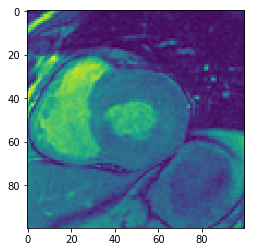

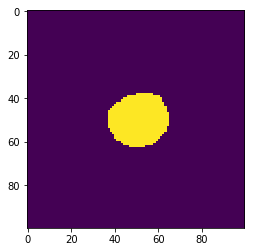

In [5]:
print(cropped_img_train.shape)
print(cropped_mask_train.shape)
plt.figure()
plt.imshow(cropped_img_train[10,:,:,0])
plt.figure()
plt.imshow(cropped_mask_train[10, :,:,0])

In [6]:
# down sampling the training image to (N, 64, 64) then reshape to (N, 4096)
from scipy import ndimage
def prepareDataSAE(X, Y, LEN = 64):
    # input should be cropped image and binary mask, shape (N, 100, 100, 1)
    # output the expected shape data for SAE model, which is (N, 4096)
    # conduct down sampling and reshaping in this method
    N = X.shape[0]
    X_re = np.zeros((N, LEN * LEN))
    Y_re = np.zeros((N, LEN * LEN))
    for i in range(N):
        img = X[i, :, :, 0]
        mask = Y[i, :, :, 0]
        img = cv2.resize(img, (LEN, LEN))
        mask = cv2.resize(mask, (LEN, LEN), interpolation = cv2.INTERSECT_NONE)
        X_re[i, :] = np.reshape(img, (-1, LEN * LEN))
        Y_re[i, :] = np.reshape(mask, (-1, LEN * LEN))
    return X_re, Y_re

def augmentData(X, y, rot = True, flip = True):
    # rotation in all 4 directions, flip in 2 direction, get total 6 times the size
    N = X.shape[0]
    w = X.shape[1]
    if rot:
        rX = np.zeros((N * 3, w, w, 1))
        rY = np.zeros((N * 3, w, w, 1))
        for i in range(N):
            img = X[i, :, :, 0]
            label = y[i, :, :, 0]
            for j in range(3):
                rx = ndimage.rotate(img, 90 * (j + 1))
                ry = ndimage.rotate(label, 90 * (j + 1))
                rX[i * 3 + j, :, :, 0] = rx
                rY[i * 3 + j, :, :, 0] = ry
    X = np.concatenate((X, rX), axis = 0)
    y = np.concatenate((y, rY), axis = 0)
    
    if flip:
        fX = np.zeros((X.shape[0], w, w, 1))
        fY = np.zeros((X.shape[0], w, w, 1))
        for i in range(X.shape[0]):
            img = X[i, :, :, 0]
            label = y[i, :, :, 0]
            fX[i, :, :, 0] = np.flipud(img)
            fY[i, :, :, 0] = np.flipud(label)
    return X, y

In [37]:
X_aug, y_aug = augmentData(cropped_img_train, cropped_mask_train)

In [7]:
print(X_aug.shape)
n = 900
plt.figure()
plt.imshow(X_aug[n,:,:,0])
plt.figure()
plt.imshow(y_aug[n, :, :, 0])

NameError: name 'X_aug' is not defined

In [76]:
X_train_SAE, Y_train_SAE = prepareDataSAE(cropped_img_train, cropped_mask_train)
X_test_SAE, Y_test_SAE = prepareDataSAE(cropped_img_test, cropped_mask_test)

(279, 4096)
(526, 4096)


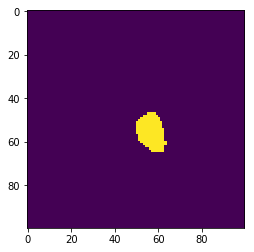

In [77]:
print(X_test_SAE.shape)
print(X_train_SAE.shape)
plt.imshow(cropped_mask_test[10,:,:,0])

In [78]:
from sklearn import decomposition
from sklearn import datasets

In [89]:
def getEigen(X, k = 400):
    avg = np.mean(X, axis = 0)
    X = X - avg
    cov = np.dot(X.T, X)
    U, s, V = np.linalg.svd(cov, full_matrices=True)
    return np.dot(U[0:k, :], X.T).T, U

In [105]:
K = 400
X_PCA_train, U = getEigen(X_train_SAE, K)


In [106]:
def model1(X_train, get_history=False, verbose=1, param_reg=0.001):
    autoencoder_1 = Sequential()
    encoder_1 = Dense(input_dim=K, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_1 = Dense(input_dim=100, units=K, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_1.add(encoder_1)
    autoencoder_1.add(decoder_1)
    autoencoder_1.compile(loss= 'mse', optimizer='adam', metrics=['accuracy'])
    h = autoencoder_1.fit(X_train, X_train, epochs=100, verbose=verbose)
    
    temp_0 = Sequential()
    temp_0.add(encoder_1)
    temp_0.compile(loss= 'mse', optimizer='adam', metrics=['accuracy'])
    if get_history:
        return h.history['loss'], encoder_1
    else:
        return encoder_1

def model2(X_train, Y_train, encoder_1, init='zero',
           get_history=False, verbose=1, param_reg=0.001):
    model = Sequential()
    model.add(encoder_1)
    model.add(Dense(input_dim=100, units=4096, kernel_initializer=init, kernel_regularizer=regularizers.l2(param_reg)))
    model.compile(optimizer = 'adam', loss = "MSE", metrics=['accuracy'])
    h = model.fit(X_train, Y_train, epochs=200, verbose=verbose)
    if get_history:
        return h.history['loss'], model
    else:
        return model


def SAE(X_train,Y_train,init='zero'):
    encoder_1 = model1(X_train)
    h, model = model2(X_train, Y_train, encoder_1,init, get_history=True)
    return h,model

In [107]:
h, model = SAE(X_PCA_train, Y_train_SAE)

Epoch 1/100
526/526 [==============================] - 1s 1ms/step - loss: 10597.0641 - acc: 0.0114
Epoch 2/100
526/526 [==============================] - 0s 91us/step - loss: 6821.3250 - acc: 0.0570
Epoch 3/100
526/526 [==============================] - 0s 83us/step - loss: 5122.0178 - acc: 0.1122
Epoch 4/100
526/526 [==============================] - 0s 87us/step - loss: 4278.0238 - acc: 0.1616
Epoch 5/100
526/526 [==============================] - 0s 85us/step - loss: 3697.3950 - acc: 0.1996
Epoch 6/100
526/526 [==============================] - 0s 83us/step - loss: 3291.6047 - acc: 0.2319
Epoch 7/100
526/526 [==============================] - 0s 81us/step - loss: 2978.2050 - acc: 0.2719
Epoch 8/100
526/526 [==============================] - 0s 85us/step - loss: 2730.4937 - acc: 0.2776
Epoch 9/100
526/526 [==============================] - 0s 88us/step - loss: 2518.7130 - acc: 0.2833
Epoch 10/100
526/526 [==============================] - 0s 83us/step - loss: 2352.9218 - acc: 0.3099

526/526 [==============================] - 0s 85us/step - loss: 675.6008 - acc: 0.5532
Epoch 83/100
526/526 [==============================] - 0s 83us/step - loss: 674.2659 - acc: 0.5418
Epoch 84/100
526/526 [==============================] - 0s 84us/step - loss: 670.8271 - acc: 0.5532
Epoch 85/100
526/526 [==============================] - 0s 82us/step - loss: 668.4172 - acc: 0.5665
Epoch 86/100
526/526 [==============================] - 0s 81us/step - loss: 665.6452 - acc: 0.5608
Epoch 87/100
526/526 [==============================] - 0s 80us/step - loss: 661.1412 - acc: 0.5608
Epoch 88/100
526/526 [==============================] - 0s 83us/step - loss: 659.9246 - acc: 0.5608
Epoch 89/100
526/526 [==============================] - 0s 81us/step - loss: 657.4854 - acc: 0.5589
Epoch 90/100
526/526 [==============================] - 0s 81us/step - loss: 656.4028 - acc: 0.5513
Epoch 91/100
526/526 [==============================] - 0s 83us/step - loss: 654.8454 - acc: 0.5627
Epoch 92/100


526/526 [==============================] - 0s 247us/step - loss: 0.0500 - acc: 0.0038
Epoch 64/200
526/526 [==============================] - 0s 248us/step - loss: 0.0487 - acc: 0.0000e+00
Epoch 65/200
526/526 [==============================] - 0s 250us/step - loss: 0.0473 - acc: 0.0038
Epoch 66/200
526/526 [==============================] - 0s 234us/step - loss: 0.0465 - acc: 0.0000e+00
Epoch 67/200
526/526 [==============================] - 0s 240us/step - loss: 0.0454 - acc: 0.0057
Epoch 68/200
526/526 [==============================] - 0s 249us/step - loss: 0.0449 - acc: 0.0038
Epoch 69/200
526/526 [==============================] - 0s 245us/step - loss: 0.0440 - acc: 0.0019
Epoch 70/200
526/526 [==============================] - 0s 255us/step - loss: 0.0431 - acc: 0.0057
Epoch 71/200
526/526 [==============================] - 0s 243us/step - loss: 0.0425 - acc: 0.0000e+00
Epoch 72/200
526/526 [==============================] - 0s 243us/step - loss: 0.0414 - acc: 0.0019
Epoch 73/20

526/526 [==============================] - 0s 255us/step - loss: 0.0152 - acc: 0.0019
Epoch 145/200
526/526 [==============================] - 0s 238us/step - loss: 0.0147 - acc: 0.0019
Epoch 146/200
526/526 [==============================] - 0s 245us/step - loss: 0.0148 - acc: 0.0019
Epoch 147/200
526/526 [==============================] - 0s 249us/step - loss: 0.0148 - acc: 0.0019
Epoch 148/200
526/526 [==============================] - 0s 240us/step - loss: 0.0146 - acc: 0.0019
Epoch 149/200
526/526 [==============================] - 0s 250us/step - loss: 0.0144 - acc: 0.0000e+00
Epoch 150/200
526/526 [==============================] - 0s 245us/step - loss: 0.0142 - acc: 0.0019
Epoch 151/200
526/526 [==============================] - 0s 243us/step - loss: 0.0148 - acc: 0.0019
Epoch 152/200
526/526 [==============================] - 0s 246us/step - loss: 0.0148 - acc: 0.0019
Epoch 153/200
526/526 [==============================] - 0s 243us/step - loss: 0.0145 - acc: 0.0038
Epoch 154/

Text(0.5,1,u'Loss Curve')

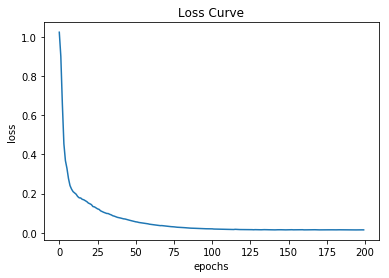

In [103]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Curve')

In [ ]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model, to_file='PCA_FC.png', show_shapes=True, show_layer_names=True)




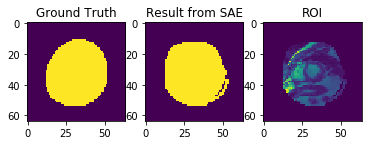

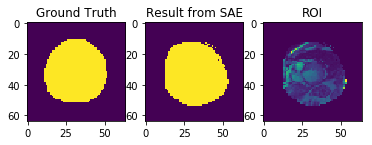

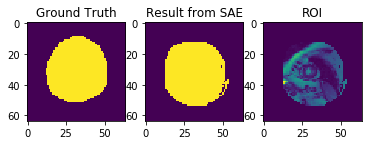

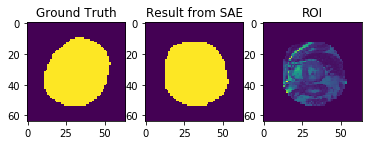

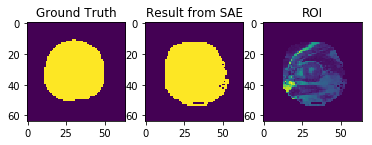

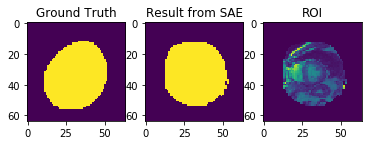

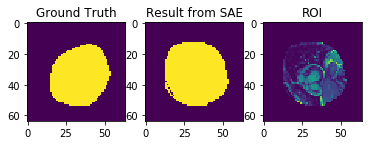

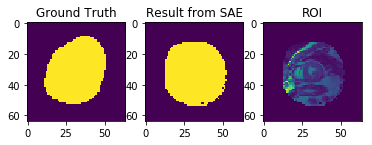

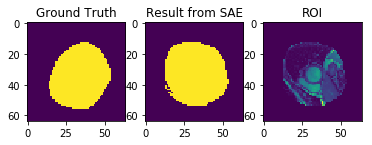

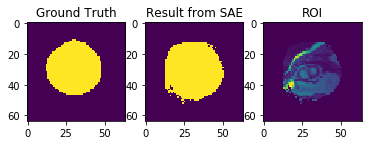

In [97]:
#find 5 highest 
demo_order = np.flip(np.argsort(dm),axis=0)
for j in range(10):
    i = demo_order[j]
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_test_SAE[i].reshape((64,64)))
    plt.title('Ground Truth')
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.title('Result from SAE')
    plt.subplot(133)
    plt.imshow(pred_img[i])
    plt.title('ROI')

In [108]:
def prediction_plot(Y_pred, idx):
    contour = Y_pred[idx].reshape((64,64))
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

#X_test_PCA = getEigen(X_test_SAE, K)
X_test_PCA = np.dot(U[0:K, :], X_test_SAE.T).T
Y_pred_PCA = model.predict(X_test_PCA)

n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(Y_pred_PCA, i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)

dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_test_SAE[i].reshape((64,64))
    dm[i] = dice_coef(Y_true, pred_mask[i])
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
    
print ('The mean dice metric is',dm.mean())
print ('The mean conformity coefficient',cc.mean())

('The mean dice metric is', 0.48632061774297347)
('The mean conformity coefficient', -3.196249656836529)


In [109]:
print(K)

400
